# Program Header

In [171]:
import pandas as pd
import numpy as np
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
from header import *

In [172]:
data_root = initialize_data_root("AY")

In [173]:
import difflib
import jellyfish
import fuzzywuzzy
from fuzzywuzzy import process

# Table of contents
1. [Import](#Import)
2. [Create Tag Map](#CreateTagMap)
5. [Save](#Save)

## Import <a name="Import"></a>

In [302]:
raw_sec_data = pd.read_csv(data_root+'02-build/clean/2019q3/sec_data_long.csv')
raw_custom_tag_map = pd.read_csv(data_root+'02-build/clean/2019q3/custom_tag_map.csv')

In [175]:
sec_data = raw_sec_data.copy()

In [307]:
custom_tag_map = raw_custom_tag_map.rename({'raw_tag':'tag'}, axis = 'columns')

## Create Tag Map <a name="CreateTagMap"></a>

Let's define a tag's reach as the percent of companies seen that include the tag. The goal of creating a tag map and consolidating raw tags is to improve the average reach.

In [208]:
def get_tag_reach(tag):
    total = sec_data.['tag'].isin([tag])
    return(sum(total)/len(sec_data.adsh.unique()))

In [284]:
all_tags = sec_data.tag.unique()

In [291]:
tag_view = sec_data.groupby('tag').nunique()['adsh'].sort_values()/len(sec_data.adsh.unique())

In [319]:
tag_view.describe()

count    18905.000000
mean         0.004235
std          0.035676
min          0.000173
25%          0.000173
50%          0.000173
75%          0.000346
max          0.986147
Name: adsh, dtype: float64

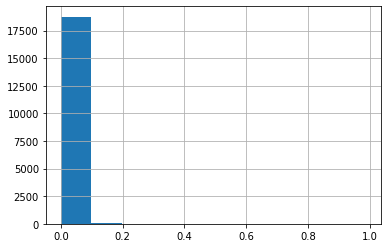

In [293]:
tag_view.hist()

Let's define a `common tag` as a tag with reach of at least 10%. We've already gone through all 149 common tags and consolidated them.

In [294]:
common_tags = tag_view.loc[tag_view >= 0.1]

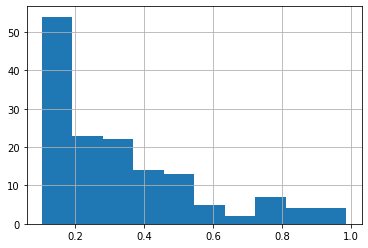

In [295]:
common_tags.hist()

Using the `common tags` list, let's find all fuzzy matches between the less common tags and the more common tags and store it in a dictionary:

In [340]:
def find_fuzzy_matches(parent_tag, children_tags):
    fuzzy_matches = process.extract(parent_tag, list(children_tags))
    matches = [i[0] for i in fuzzy_matches]
    return(matches)

In [330]:
less_common_tags = tag_view.loc[tag_view < 0.1].index
tag_map = {}

In [335]:
for i in common_tags.oindex:
    print(i)

SubleaseIncome
DeferredFinanceCostsNet
InventoryWorkInProcessNetOfReserves
ContractWithCustomerLiabilityNoncurrent
OtherLiabilities
DeferredIncomeTaxAssetsNet
VariableLeaseCost
SellingAndMarketingExpense
InventoryFinishedGoods
DueToRelatedPartiesCurrent
DeferredTaxAssetsValuationAllowance
StockIssuedDuringPeriodValueNewIssues
LiabilitiesNoncurrent
RevenueFromContractWithCustomerIncludingAssessedTax
UnrecognizedTaxBenefits
OtherComprehensiveIncomeUnrealizedHoldingGainLossOnSecuritiesArisingDuringPeriodNetOfTax
AccruedIncomeTaxesCurrent
LaborAndRelatedExpense
WeightedAverageNumberDilutedSharesOutstandingAdjustment
EffectiveIncomeTaxRateContinuingOperations
InventoryFinishedGoodsNetOfReserves
ShareBasedCompensation
ProfessionalFees
DividendsCommonStockCash
IncomeLossFromEquityMethodInvestments
CashCashEquivalentsRestrictedCashAndRestrictedCashEquivalentsIncludingDisposalGroupAndDiscontinuedOperations
DeferredIncomeTaxLiabilitiesNet
DebtInstrumentCarryingAmount
Cash
EntityCommonStockShares

In [341]:
for i in common_tags.index:
    matches = find_fuzzy_matches(i, less_common_tags)
    tag_map[i] = matches

Found matches for SubleaseIncome
Found matches for DeferredFinanceCostsNet
Found matches for InventoryWorkInProcessNetOfReserves
Found matches for ContractWithCustomerLiabilityNoncurrent
Found matches for OtherLiabilities
Found matches for DeferredIncomeTaxAssetsNet
Found matches for VariableLeaseCost
Found matches for SellingAndMarketingExpense
Found matches for InventoryFinishedGoods
Found matches for DueToRelatedPartiesCurrent
Found matches for DeferredTaxAssetsValuationAllowance
Found matches for StockIssuedDuringPeriodValueNewIssues
Found matches for LiabilitiesNoncurrent
Found matches for RevenueFromContractWithCustomerIncludingAssessedTax
Found matches for UnrecognizedTaxBenefits
Found matches for OtherComprehensiveIncomeUnrealizedHoldingGainLossOnSecuritiesArisingDuringPeriodNetOfTax
Found matches for AccruedIncomeTaxesCurrent
Found matches for LaborAndRelatedExpense
Found matches for WeightedAverageNumberDilutedSharesOutstandingAdjustment
Found matches for EffectiveIncomeTaxRa

We'll convert these dictionary tag maps to a data-frame to easily use SQL-style joins.

In [351]:
tag_map_df = pd.DataFrame(columns = ['clean_tag_pt1', 'tag'])
tag_map_df

,clean_tag_pt1,tag


In [372]:
map_df_intermediate = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in tag_map.items()]))\
            .melt()\
            .dropna()\
            .rename({'variable':'tag', 'value':'raw_tag'}, axis = 'columns')\
            .drop_duplicates('raw_tag', keep = False)

In [373]:
map_df_intermediate.shape

(557, 2)

Now, we will use the custom tag map that consolidates the `common tags`. This was created using accounting and financial statement handbook resources and also required human judgment.

In [389]:
map_df = map_df_intermediate.merge(custom_tag_map, on = ['tag'])\
    .drop('tag', axis = 'columns')\
    .rename({'raw_tag':'tag'}, axis = 'columns')

In [390]:
map_df.head()

,tag,clean_tag
0,OperatingLeaseExpenseNetOfSubleaseIncome,SubleaseIncome
1,RentExpenseClosedStoresNetOfSubleaseIncome,SubleaseIncome
2,LeaseIncome,SubleaseIncome
3,SbaIncome,SubleaseIncome
4,OperatingLeaseLeaseIncomeTenantReimbursements,SubleaseIncome


We've mapped the less common tags to their proper clean tag counterpart. Now, we will add on the clean tags of the `common tags` to the map as well.

In [391]:
common_tags_cleaned = pd.DataFrame(common_tags.index).merge(custom_tag_map, on = ['tag'])

In [394]:
tag_map = pd.concat([map_df, common_tags_cleaned])

Let's see the results of our cleaning:

In [397]:
cleaned_sec = sec_data.merge(tag_map, on = ['tag'])
clean_tag_view = cleaned_sec.groupby('clean_tag').nunique()['adsh'].sort_values()/len(cleaned_sec.adsh.unique())

In [398]:
clean_tag_view.describe()

count    89.000000
mean      0.453132
std       0.264031
min       0.106357
25%       0.219816
50%       0.411398
75%       0.627230
max       0.986489
Name: adsh, dtype: float64

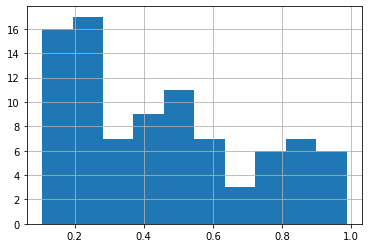

In [399]:
clean_tag_view.hist()

Much better!

So we see that our manual matching process has dramatically improved coverage among the common tags. Now, let's use fuzzywuzzy to classify less column tags as part of the common tags:

In [17]:
print("Consolidated ",round((1-len(tag_map_df.clean_tag.unique())/len(tag_map_df.tag.unique()))*100,2),"% of tags", sep = "")

Consolidated 78.11% of tags


## Save <a name="Save"></a>
Save tag map to build/clean

In [20]:
# Save
tag_map_df.to_csv(data_root+'02-build/clean/2019q3/tag_map.csv', index = False)